<a href="https://colab.research.google.com/github/diputs03/AI-Studies/blob/main/Creating_network/dymamic_architect_rebuilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Aiming a Dynaimic Graph-structured NeuronNetwork
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from collections import deque

In [11]:
"""
Activation function in this case in tanh
Loss is the Euclidean loss
"""
class Model:
  class Neuron:
    def __init__(self, name, prev, next):
      self.name, self.prev, self.next = name, prev, next
      self.bias = np.random.uniform(-0.1, 0.1)

  def __init__(self, input_size, output_size):
    self.Input_layer = [Model.Neuron(f"input{i}", [], []) for i in range(input_size)]
    self.Output_layer = [Model.Neuron(f"output{o}", [], []) for o in range(output_size)]
    for i in range(input_size): self.Input_layer[i].next = self.Output_layer
    for o in range(output_size): self.Output_layer[o].prev = self.Input_layer
    self.weight = {}
    for u in self.Input_layer:
      for v in self.Output_layer:
        self.weight[(u,v)] = np.random.uniform(-0.1, 0.1)
    self.all_neurons = self.Input_layer + self.Output_layer

  def forward(self, X, batch_size):
    assert X.shape == (batch_size,len(self.Input_layer))
    a = {q: np.zeros(batch_size) for q in self.all_neurons}

    for i, n in enumerate(self.Input_layer):
      a[n] = X[:, i]

    q = deque()
    for i in self.Input_layer:
      q.append(i)

    cnt = {q: 0 for q in self.all_neurons}

    while len(q) != 0:
      c = q.popleft()
      a[c] = np.tanh(a[c] + c.bias)
      for n in c.next:
        a[n] = a[n] + a[c] * self.weight[(c,n)]
        cnt[n] += 1
        if cnt[n] == len(n.prev):
          q.append(n)
    return a

  def eval(self, X):
    a = self.forward(X, len(X))
    return np.array([a[o] for o in self.Output_layer]).T

  def backward(self, X, Y, batch_size, learning_rate):
    assert X.shape == (batch_size,len(self.Input_layer))
    assert Y.shape == (batch_size,len(self.Output_layer))
    a = self.forward(X, batch_size)
    par_a = {q: np.zeros(batch_size) for q in self.all_neurons}
    for o, n in enumerate(self.Output_layer):
      par_a[n] = 2 * (a[n] - Y[:, o])

    q = deque()
    for o in self.Output_layer:
      q.append(o)

    cnt = {q: 0 for q in self.all_neurons}

    while len(q) != 0:
      c = q.popleft()
      par_b = par_a[c] * (1-a[c]**2)
      c.bias -= np.mean(par_b) * learning_rate
      for p in c.prev:
        par_a[p] += par_a[c] * (1-a[c]**2) * self.weight[(p,c)]
        par_w_pc = par_a[c] * (1-a[c]**2) * a[p]
        self.weight[(p,c)] -= np.mean(par_w_pc) * learning_rate
        cnt[p] += 1
        if cnt[p] == len(p.next):
          q.append(p)

  def addLayer(self, mid_size, UP, DOWN):
    Mid_layer = [Model.Neuron(f"mid{o}", [], []) for o in range(mid_size)]
    for m, mid in enumerate(Mid_layer):
      Mid_layer[m].prev = UP
      for u in UP:
        self.weight[(u,mid)] = np.random.uniform(-0.1, 0.1)
      Mid_layer[m].next = DOWN
      for v in DOWN:
        self.weight[(mid,v)] = np.random.uniform(-0.1, 0.1)
    for u in UP:
      u.next = Mid_layer
    for v in DOWN:
      v.prev = Mid_layer
    for u in UP:
      for v in DOWN:
        self.weight.pop((u, v))
    self.all_neurons += Mid_layer
    return Mid_layer

  def train(self, X, Y, batch_size, epochs, learning_rate):
    l = len(X)
    for epoch in range(epochs):
      data=[(X[_], Y[_]) for _ in range(len(X))]
      random.shuffle(data)
      for _ in range(len(X)):
        X[_],Y[_]=data[_]
      loss = 0
      for batch in range(int(l / batch_size)):
        L, R = batch * batch_size, (batch + 1) * batch_size
        x_train, y_train = X[L:R], Y[L:R]
        self.backward(x_train, y_train, batch_size, learning_rate)
        output = self.eval(x_train)
        loss += np.sum(((y_train - output) ** 2), axis=(0,1))
      loss = ((loss) ** 0.5) / (int(l / batch_size) * batch_size)
      print(f"Epoch {epoch}/{epochs}, Loss:{loss}")

In [ ]:
X=np.array([[0,0],[0,1],[1,0],[1,1]])
Y=np.array([[0],[1],[1],[0]])
mod=Model(2, 1)
mid1=mod.addLayer(4, mod.Input_layer, mod.Output_layer)
mod.addLayer(4, mid1, mod.Output_layer)
mod.eval(X)

array([[0.05312619],
       [0.05317977],
       [0.05292535],
       [0.0529803 ]])

In [ ]:
mod.train(X, Y, 4, 500, 0.1)

Epoch 0, Loss:0.011048444954117331
Epoch 1, Loss:0.011042339979862315
Epoch 2, Loss:0.011036244496605507
Epoch 3, Loss:0.011030158480130281
Epoch 4, Loss:0.011024081906306049
Epoch 5, Loss:0.011018014751087657
Epoch 6, Loss:0.011011956990515048
Epoch 7, Loss:0.011005908600712877
Epoch 8, Loss:0.010999869557890118
Epoch 9, Loss:0.01099383983833968
Epoch 10, Loss:0.010987819418438183
Epoch 11, Loss:0.010981808274645233
Epoch 12, Loss:0.010975806383503484
Epoch 13, Loss:0.0109698137216378
Epoch 14, Loss:0.010963830265755314
Epoch 15, Loss:0.010957855992644705
Epoch 16, Loss:0.010951890879176196
Epoch 17, Loss:0.01094593490230078
Epoch 18, Loss:0.010939988039050164
Epoch 19, Loss:0.010934050266536322
Epoch 20, Loss:0.01092812156195111
Epoch 21, Loss:0.010922201902565876
Epoch 22, Loss:0.010916291265731182
Epoch 23, Loss:0.010910389628876416
Epoch 24, Loss:0.010904496969509458
Epoch 25, Loss:0.01089861326521624
Epoch 26, Loss:0.010892738493660625
Epoch 27, Loss:0.010886872632583755
Epoch 28

In [ ]:
print(X, Y)
mod.eval(X)

[[1 0]
 [1 0]
 [1 0]
 [1 0]] [[1]
 [1]
 [1]
 [1]]


array([[0.98233139],
       [0.98233139],
       [0.98233139],
       [0.98233139]])

In [12]:
import tensorflow as tf
tf.random.set_seed(42)
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images to 1D vector of 784 features (28*28)
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def test(model, X, Y, batch_size):
  k = int(len(X)/batch_size)
  for i in range(k):
    Y_hat=model.eval(X[i*batch_size:(i+1)*batch_size])
    wrong=0
    for j in range(batch_size):
      max1,max2,id1,id2=-999,-999,-1,-1
      for l in range(10):
        if max1 < Y_hat[j][l]:
          max1,id1=Y_hat[j][l],l
        if max2 < Y[i*batch_size+j][l]:
          max2,id2=Y[i*batch_size+j][l],l
      if id1 != id2: wrong+=1
    print(f"batch: {i}, accuracy: {(batch_size-wrong)/batch_size*100}%")
mod2 = Model(784, 10)
mod2.addLayer(32, mod2.Input_layer, mod2.Output_layer)

784
Epoch 0/10, Loss:0.030306411273519223
Epoch 1/10, Loss:0.027844793537530728
Epoch 2/10, Loss:0.026543731328158553
Epoch 3/10, Loss:0.02529161081348907
Epoch 4/10, Loss:0.024208623470901833
Epoch 5/10, Loss:0.023377935757644738
Epoch 6/10, Loss:0.02251910347233744
Epoch 7/10, Loss:0.021511433499755515
Epoch 8/10, Loss:0.02078484056665236
Epoch 9/10, Loss:0.02036742728885913
[[-0.04050386  0.66182411  0.15279259  0.01910416 -0.04179198  0.05049054
  -0.07468635  0.13628532  0.06616975  0.01633942]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
batch: 0, accuracy: 56.8%
batch: 1, accuracy: 53.400000000000006%
batch: 2, accuracy: 55.00000000000001%
batch: 3, accuracy: 54.0%
batch: 4, accuracy: 54.2%
batch: 5, accuracy: 54.2%
batch: 6, accuracy: 59.199999999999996%
batch: 7, accuracy: 52.800000000000004%
batch: 8, accuracy: 51.0%
batch: 9, accuracy: 53.800000000000004%
batch: 10, accuracy: 68.2%
batch: 11, accuracy: 63.0%
batch: 12, accuracy: 70.6%
batch: 13, accuracy: 62.6%
batch: 14, accuracy: 67.4

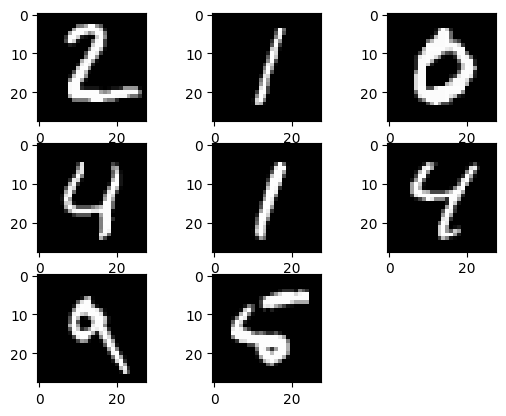

In [13]:
print(len(mod2.Input_layer))
mod2.train(x_train[0:1024], y_train[0:1024], 32, 10, 0.01)
for i in range(1,9):
  plt.subplot(330+i)
  plt.imshow(x_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
print(mod2.eval(np.array([x_test[5]])))
print(y_test[5])
test(mod2, x_test, y_test, 500)

In [14]:
test(mod2, x_test, y_test, 5000)

batch: 0, accuracy: 54.44%
batch: 1, accuracy: 67.80000000000001%


the model here aim to some how echo back propagation